In [19]:
!pip install torch-geometric
!pip install umap-learn
!pip3 install torch

In [20]:
# Dataset

import torch.nn as nn

import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborLoader

import matplotlib.pyplot as plt
import umap
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Cora()
-------------------
Number of graphs: 1
Number of nodes: 2708
Number of features: 1433
Number of classes: 7

Graph:
------
Training nodes: 140
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


In [ ]:
# TORCH = "1.4.0"
# CUDA = "cu101"
# %pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# %pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# %pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# %pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${TORCH}+${CUDA}.html
# %pip install torch-geometric

In [18]:
data.edge_index
edge_index = data.edge_index
edges = edge_index.t().numpy()
graph = nx.from_edgelist(edges, create_using=nx.Graph())

In [ ]:
# # torch-sparse 설치가 안됨,,, 이건 패스
# train_loader = NeighborLoader(
#     data,
#     num_neighbors = [25, 10],
#     batch_size = 32, # batch 5개
#     input_nodes = data.train_mask
# )

# for i, subgraph in enumerate(train_loader):
#     print(f'Subgraph {i}: {subgraph}')

In [46]:
import torch
import torch.nn as nn
import torch.nn.init as init
import random

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

class GraphSAGE(nn.Module):
  def __init__(self, dataset = data, in_feats= 1433, k = 2, out_feats = 256, aggregator_type = "mean", dropout = 0.5, lr = 5e-4, wd = 5e-4, epochs = 50):
    super(GraphSAGE, self).__init__()
    '''
    GraphSAGE
    type으로는 {GCN, mean, maxpooling, LSTM}

    구현은 mean의 경우만

    k번 loop 돌면서 배치안의 노드에 대해서 일정수의 이웃 노드를 aggregate
    마지막 output이 최종 represntation -> 얘로 classification

    원래는 Neighbor로 batch loader해야하는데 코랩에서는 pytorch-sparse 설치가 안됨

    '''
    self.lr = lr
    self.wd = wd
    self.k = k # k = 2면 충분
    self.dataset = dataset
    self.activation = nn.ReLU()

    self. dropout = dropout
    self.aggregator_type = aggregator_type
    self.W = nn.Parameter(torch.Tensor(2 * in_feats, in_feats))

    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=self.lr)
                                     # weight_decay= self.wd)
    self.criterion = torch.nn.CrossEntropyLoss()
    self.epochs = epochs
    # self.train_loader = train_loader

    self.z = self.dataset.x.clone() # output embedding 저장

    init.xavier_uniform_(self.W)
    print("Initialize W ... Done!")


  def forward(self):
    edges = self.dataset.edge_index.t().numpy()
    graph = nx.from_edgelist(edges, create_using=nx.Graph())

    for kk in range(self.k):
      '''
      k - hop neighbor까지
      원래는 k = 0일때 node feature로 node embedding 구함
      근데 Cora에서는 node feature 바로 사용
      그래서 Neighbor로 batch 뽑을 때는 [10, 25]로 이웃 제한이 되는데 얘는 직접
      '''
      total_loss = 0
      for v in range(len(self.dataset.train_mask)):
        if self.dataset.train_mask[v]:
          # train data인 경우 근데 이게 최선일까...??????????????,,,,,,,,
          neighbor_indices = self.dataset.edge_index[1][self.dataset.edge_index[0] == v]
          # 애초에 train data가 140개고 이웃이 10개 안넘을듯,,,
          neighbor_features = self.z[neighbor_indices,:]
          aggregated_features = torch.mean(neighbor_features, dim=0)
          concatenated_features = torch.cat([self.z[v], aggregated_features])
          #print("concated size", concatenated_features.shape)

          self.z[v] =  torch.matmul(concatenated_features, self.W) # (2I, I) * (2I)
         # print("output", self.z[v].shape)

          # positive pair Zu는 random walk에서 빈번히 발생하는 node
          # negative pair Zvn은 어떤 확률 분포 Pn을 따름
          # 그냥 이웃의 random 이웃 뽑자,, 2-hop neighbor인셈!
          one_hop_neighbor = random.choice(list(graph.neighbors(v)))

          zu = random.choice(list(graph.neighbors(one_hop_neighbor)))
          zvn = random.choices(list(graph.nodes()), k=10)

          pos_pair = torch.matmul(self.z[zu].t(), self.z[v])
          pos_loss = -torch.log(nn.Sigmoid()(pos_pair))
          neg_pair = torch.matmul(self.z[zu], self.z[zvn].t())  # (I) (10, I) 논문에서는 Q가 개수인데 ... 뭔가 이상함
          neg_loss = nn.Sigmoid()(-torch.sum(neg_pair)) / 10
          loss = pos_loss -  -torch.log(neg_loss)

          total_loss += loss

    return total_loss / len(self.dataset.train_mask)

  def fit(self):
    self.train()
    for epoch in range(self.epochs):
      total_loss = []
      acc = 0
      self.optimizer.zero_grad()
      loss = self()
      self.optimizer.step()

      if epoch % 1 == 0:
        acc = 0
        #acc = accuracy(out[self.dataset.train_mask].argmax(dim=1), self.dataset.y[self.dataset.train_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc:.2f}%')
      # for batch in self.train_loader:
      #   self.optimizer.zero_grad()
      #   out, loss_objective = self(batch.x, batch.edge_index)
      #   loss = self.criterion(out[batch.train_mask], batch.y[batch.train_mask])
      #   total_loss_objective += loss_objective.item()
      #   total_loss += loss.item()
      #   acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
      #   loss_objective.backward()
      #   self.optimizer.step()

      #   if epoch % 20 == 0:
      #     print(f'Epoch {epoch:>3} | Train Loss: {total_loss_objective/len(train_loader):.3f}| Train Loss: {total_loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:.2f}%')


model = GraphSAGE()
print(model)
# Train
model.fit()


Initialize W ... Done!
GraphSAGE(
  (activation): ReLU()
  (criterion): CrossEntropyLoss()
)
Epoch   0 | Train Loss: -0.456 | Train Acc: 0.00%
Epoch   1 | Train Loss: -0.507 | Train Acc: 0.00%
Epoch   2 | Train Loss: -0.421 | Train Acc: 0.00%
Epoch   3 | Train Loss: -0.481 | Train Acc: 0.00%
Epoch   4 | Train Loss: -0.431 | Train Acc: 0.00%
Epoch   5 | Train Loss: -0.517 | Train Acc: 0.00%
Epoch   6 | Train Loss: -0.459 | Train Acc: 0.00%
Epoch   7 | Train Loss: -0.526 | Train Acc: 0.00%
Epoch   8 | Train Loss: -0.454 | Train Acc: 0.00%
Epoch   9 | Train Loss: -0.469 | Train Acc: 0.00%
Epoch  10 | Train Loss: -0.513 | Train Acc: 0.00%
Epoch  11 | Train Loss: -0.449 | Train Acc: 0.00%
Epoch  12 | Train Loss: -0.462 | Train Acc: 0.00%
Epoch  13 | Train Loss: -0.507 | Train Acc: 0.00%
Epoch  14 | Train Loss: -0.492 | Train Acc: 0.00%
Epoch  15 | Train Loss: -0.459 | Train Acc: 0.00%
Epoch  16 | Train Loss: -0.515 | Train Acc: 0.00%
Epoch  17 | Train Loss: -0.495 | Train Acc: 0.00%
Epoch  

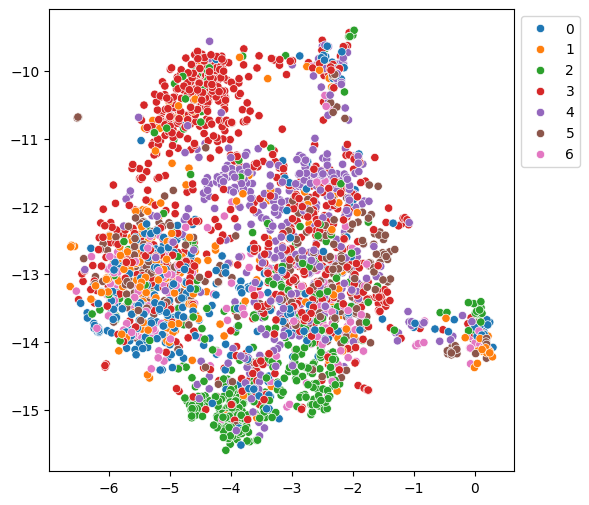

In [48]:
out_numpy = model.z.detach().cpu().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

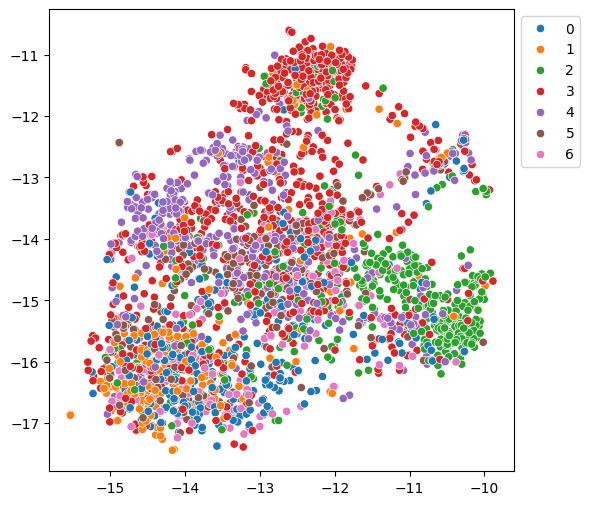

In [51]:
out_numpy = data.x
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

In [55]:
import torch
import torch.nn as nn
import torch.nn.init as init
import random

def accuracy(pred_y, y):
    return ((pred_y == y).sum() / len(y)).item()

class GraphSAGE(nn.Module):
  def __init__(self, dataset = data, in_feats= 1433, k = 2, out_feats = 256, aggregator_type = "mean", dropout = 0.5, lr = 5e-4, wd = 5e-4, epochs = 2):
    super(GraphSAGE, self).__init__()
    '''
    GraphSAGE

    train 아니라 그냥 전부...

    '''
    self.lr = lr
    self.wd = wd
    self.k = k # k = 2면 충분
    self.dataset = dataset
    self.activation = nn.ReLU()

    self. dropout = dropout
    self.aggregator_type = aggregator_type
    self.W = nn.Parameter(torch.Tensor(2 * in_feats, in_feats))

    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=self.lr)
                                     # weight_decay= self.wd)
    self.criterion = torch.nn.CrossEntropyLoss()
    self.epochs = epochs
    # self.train_loader = train_loader

    self.z = self.dataset.x.clone() # output embedding 저장

    init.xavier_uniform_(self.W)
    print("Initialize W ... Done!")


  def forward(self):
    edges = self.dataset.edge_index.t().numpy()
    graph = nx.from_edgelist(edges, create_using=nx.Graph())

    for kk in range(self.k):
      '''
      k - hop neighbor까지
      원래는 k = 0일때 node feature로 node embedding 구함
      근데 Cora에서는 node feature 바로 사용
      그래서 Neighbor로 batch 뽑을 때는 [10, 25]로 이웃 제한이 되는데 얘는 직접
      '''
      total_loss = 0
      l = self.dataset.x.shape[0]
      for v in range(l):
          neighbor_indices = self.dataset.edge_index[1][self.dataset.edge_index[0] == v][:10]

          neighbor_features = self.z[neighbor_indices,:]
          aggregated_features = torch.mean(neighbor_features, dim=0)
          concatenated_features = torch.cat([self.z[v], aggregated_features])

          self.z[v] =  torch.matmul(concatenated_features, self.W) # (2I, I) * (2I)

          one_hop_neighbor = random.choice(list(graph.neighbors(v)))

          zu = random.choice(list(graph.neighbors(one_hop_neighbor)))
          zvn = random.choices(list(graph.nodes()), k=10)

          pos_pair = torch.matmul(self.z[zu].t(), self.z[v])
          pos_loss = -torch.log(nn.Sigmoid()(pos_pair))
          neg_pair = torch.matmul(self.z[zu], self.z[zvn].t())  # (I) (10, I) 논문에서는 Q가 개수인데 ... 뭔가 이상함
          neg_loss = nn.Sigmoid()(-torch.sum(neg_pair)) / 10
          loss = pos_loss -  -torch.log(neg_loss)

          total_loss += loss

    return total_loss / l

  def fit(self):
    self.train()
    for epoch in range(self.epochs):
      total_loss = []
      acc = 0
      self.optimizer.zero_grad()
      loss = self()
      self.optimizer.step()

      if epoch % 1 == 0:
        acc = 0
        #acc = accuracy(out[self.dataset.train_mask].argmax(dim=1), self.dataset.y[self.dataset.train_mask])
        print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: {acc:.2f}%')
      # for batch in self.train_loader:
      #   self.optimizer.zero_grad()
      #   out, loss_objective = self(batch.x, batch.edge_index)
      #   loss = self.criterion(out[batch.train_mask], batch.y[batch.train_mask])
      #   total_loss_objective += loss_objective.item()
      #   total_loss += loss.item()
      #   acc += accuracy(out[batch.train_mask].argmax(dim=1), batch.y[batch.train_mask])
      #   loss_objective.backward()
      #   self.optimizer.step()

      #   if epoch % 20 == 0:
      #     print(f'Epoch {epoch:>3} | Train Loss: {total_loss_objective/len(train_loader):.3f}| Train Loss: {total_loss/len(train_loader):.3f} | Train Acc: {acc/len(train_loader)*100:.2f}%')


model = GraphSAGE()
print(model)
# Train
model.fit()


Initialize W ... Done!
GraphSAGE(
  (activation): ReLU()
  (criterion): CrossEntropyLoss()
)
Epoch   0 | Train Loss: -10.301 | Train Acc: 0.00%
Epoch   1 | Train Loss: -18.155 | Train Acc: 0.00%


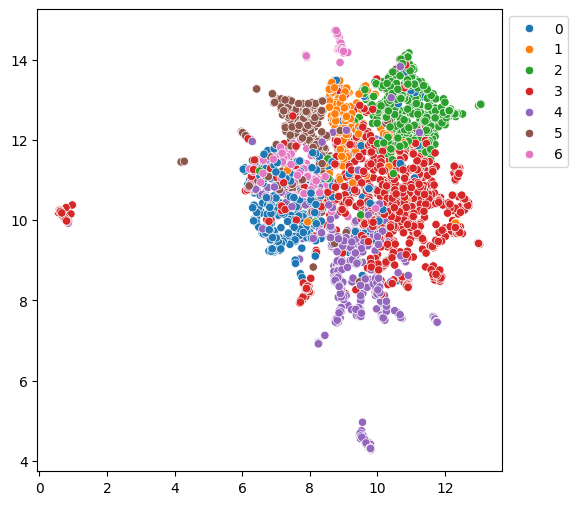

In [57]:
out_numpy = model.z.detach().numpy()
palette = {}
import seaborn as sns
for n, y in enumerate(set(data.y.cpu().numpy())):
    palette[y] = f'C{n}'
# UMAP visualization
embd = umap.UMAP().fit_transform(out_numpy)
plt.figure(figsize=(6, 6))
sns.scatterplot(x=embd.T[0], y=embd.T[1], hue=data.y.cpu().numpy(), palette=palette)
plt.legend(bbox_to_anchor=(1,1), loc='upper left')

???????????????????
학습이 된걸까..........

오 된듯!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! 미쳣다리
근데 2회 이후로는 loss가 무한대로 발산함,,,,,,,,,,,,,,,,,,,,,,,,,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,,,,,,,,,,,,,,,

https://github.com/williamleif/GraphSAGE/blob/master/graphsage/prediction.py

아직 잘..이해는 안됨